In [14]:
# requirements
pip install rich
pip install tabulate


In [75]:

# 打开数据库
# 导入wx zfb# requirements
pip install rich
pip install tabulate
# 跳过列
# 某些列格式处理 错误时间列

import csv
import sqlite3
import re


# 核心方法
# region
def import_csv_to_sqlite(csv_file_path, db_path, table_name, strategy, header_row=0, start_row=0, skip_columns=None, params=None):
    """
    导入CSV文件到SQLite数据库，并根据策略执行相应的SQL
    :param csv_file_path: CSV文件路径
    :param db_path: 数据库文件路径
    :param table_name: 临时表名
    :param strategy: 导入策略 ('refund', 'income', 'expense', 'transfer', 'other')
    :param header_row: 表头所在的行号（从0开始）
    :param start_row: 数据开始的行号（从0开始）
    :param skip_columns: 要跳过的列索引列表
    :param params: 策略所需的额外参数，如 monthyear 等
    """
    if skip_columns is None:
        skip_columns = []
    if params is None:
        params = {}

    try:
        encodings = ['gb2312', 'gbk', 'gb18030', 'utf-8']
        # encodings = ['utf-8']

        for encoding in encodings:
            try:
                conn = sqlite3.connect(db_path)
                cursor = conn.cursor()

                # 首先导入CSV到临时表
                with open(csv_file_path, 'r', encoding=encoding) as csvfile:
                    csv_reader = csv.reader(csvfile)

                    # 跳过header_row之前的行
                    for _ in range(header_row):
                        next(csv_reader)

                    # 读取表头行
                    headers = next(csv_reader)

                    # 过滤掉要跳过的列
                    filtered_headers = [h for i, h in enumerate(headers) if i not in skip_columns]
                    cleaned_headers = [sanitize_column_name(header) for header in filtered_headers]

                    # 创建临时表
                    strategy_table_name = f"t_{table_name}_{strategy}"

                    # 使用该方法
                    if rename_existing_table(cursor, strategy_table_name):
                        print(f"表 {table_name} 已存在")
                    else:
                        print(f"表 {table_name} 不存在或重命名失败")

                        # 创建临时表
                        create_strategy_table_query = f"""
                            CREATE TABLE IF NOT EXISTS {strategy_table_name} (
                                {', '.join([f'[{col}] {get_column_type(col)}' for col in cleaned_headers])}
                            )
                            """
                        cursor.execute(create_strategy_table_query)

                        # 跳过start_row之前的行
                        remaining_rows_to_skip = start_row - (header_row + 1)
                        if remaining_rows_to_skip > 0:
                            for _ in range(remaining_rows_to_skip):
                                next(csv_reader)

                        # 插入数据到临时表
                        for row in csv_reader:
                            if not row:  # 跳过空行
                                continue

                            filtered_row = []

                            for i, value in enumerate(row):
                                if i not in skip_columns:
                                    # 如果对应的header是金额列，进行数据清理
                                    if i < len(cleaned_headers) and is_money_column(cleaned_headers[i]):
                                        # print(cleaned_headers[i])
                                        filtered_row.append(clean_money_value(value))
                                    else:
                                        (filtered_row).append(value)

                            if len(filtered_row) == len(cleaned_headers):
                                placeholders = ','.join(['?' for _ in filtered_row])
                                insert_query = f"INSERT INTO {strategy_table_name} VALUES ({placeholders})"
                                try:
                                    cursor.execute(insert_query, filtered_row)
                                except Exception as e:
                                    print(f"插入失败: {e}")
                                    print(f"插入的数据: {filtered_row}")

                # 根据策略执行相应的SQL将数据导入正式表
                create_table_query = sql_createScheme_payMonthYear(table_name)
                cursor.execute(create_table_query)

                if strategy == 'wx':
                    # 微信策略SQL

                    # 导入消费
                    sql1 = f"""
                    INSERT INTO [{table_name}] (id, pay_time, pay_monthyear, pay_source, pay_note, pay_money, pay_tag, app_source)
                         SELECT
                         strftime('%s',[交易时间]) as id,
                         [交易时间] as pay_time,
                         '{params.get('monthyear')}' as pay_monthyear,
                         [交易对方] as pay_source,
                         [商品] as pay_note,
                         cast([金额元] as real)  as pay_money,
                         'N' as 'pay_tag',
                         'wx' as 'app_source'
                         FROM '{strategy_table_name}' where [收支]='支出'
                    """

                    # 导入收入-红包退款-红包转账
                    sql2 = f"""
                    INSERT INTO [{table_name}] (id, pay_time, pay_monthyear, pay_source, pay_note, pay_money, pay_tag, app_source)
                         SELECT
                         strftime('%s',[交易时间]) as id,
                         [交易时间] as pay_time,
                         '{params.get('monthyear')}' as pay_monthyear,
                         [交易对方] as pay_source,
                         ([商品] || [当前状态]) as pay_note,
                         cast(-[金额元] as real)  as pay_money, 
                         'N' as 'pay_tag',
                         'wx' as 'app_source'
                         FROM '{strategy_table_name}' where [收支]='收入'
                    """
                    cursor.execute(sql1)
                    cursor.execute(sql2)
                    # pass

                elif strategy == 'zfb':
                    # 支付宝策略SQL

                    # 导入消费
                    sql3 = f"""
                    INSERT INTO [{table_name}] (id, pay_time, pay_monthyear, pay_source, pay_note, pay_money, pay_tag, app_source) 
                         SELECT
                         strftime('%s',[交易创建时间]) as id,
                         [交易创建时间] as pay_time,
                         '{params.get('monthyear')}' as pay_monthyear,
                         [交易对方] as pay_source,
                         [商品名称] as pay_note,
                         [金额元] as pay_money,
                         'N' as 'pay_tag',
                         'ali' as 'app_source'
                         FROM '{strategy_table_name}'  where [收支] like '支出%'  and [交易状态] like '交易成功%' and [成功退款元]=0
                    """

                    # 导入退款
                    sql4 = f"""
                    INSERT INTO [{table_name}] (id, pay_time, pay_monthyear, pay_source, pay_note, pay_money, pay_tag, app_source) 
                         SELECT
                         strftime('%s',[交易创建时间]) as id,
                         [交易创建时间] as pay_time,
                         '{params.get('monthyear')}' as pay_monthyear,
                         [交易对方] as pay_source, 
                         [商品名称] as pay_note, 
                         [金额元]-[成功退款元]  as pay_money,
                         'N' as 'pay_tag',
                         'ali' as 'app_source'
                         FROM '{strategy_table_name}'  where  [交易状态] like '交易成功%' and [成功退款元]>0
                    """
                    cursor.execute(sql3)
                    cursor.execute(sql4)
                    # pass

                elif strategy == 'yh':
                    # 银行信用卡策略SQL
                    # 在这里添加支出策略的SQL
                    pass

                elif strategy == 'other':
                    # 其他SQL
                    # 在这里添加转账策略的SQL
                    pass

                # 提交事务
                conn.commit()

                # 删除临时表
                # cursor.execute(f"DROP TABLE IF EXISTS {strategy_table_name}")
                # conn.commit()

                print(f"成功使用 {encoding} 编码导入CSV并执行{strategy}策略")
                return

            except UnicodeDecodeError:
                conn.close()
                continue
            except sqlite3.Error as e:
                print(f"SQLite错误: {e}")
                conn.close()

        print("无法使用指定的任何编码解码文件")

    except Exception as e:
        print(f"发生错误: {e}")
    finally:
        if 'conn' in locals():
            conn.close()
# endregion


# 工具方法和策略
# region
def sanitize_column_name(name):
    # 清理列名，确保符合SQLite标识符规范
    # 删除非字母数字字符，确保以字母开头
    cleaned_name = re.sub(r'\W+', '', name)
    if cleaned_name[0].isdigit():
        cleaned_name = '' + cleaned_name
    return cleaned_name.lower()


def sql_createScheme_payMonthYear(table_name: str):
    return f"""
    CREATE TABLE IF NOT EXISTS {table_name}  (
      id BIGINT NOT NULL,
      pay_time VARCHAR NOT NULL,
      pay_monthyear VARCHAR NOT NULL,
      pay_source VARCHAR,
      pay_note VARCHAR,
      pay_money NUMERIC NOT NULL,
      pay_tag VARCHAR,
      app_source VARCHAR,
      PRIMARY KEY (id, pay_monthyear, pay_money)
    )
    """


def get_column_type(column_name):
    """
    根据列名确定数据类型
    """
    # 金额相关的列名关键字
    money_keywords = ['金额', '退款', '价格', '费用', '余额', '服务费']

    # 检查列名是否包含金额相关关键字
    if any(keyword in column_name for keyword in money_keywords):
        return 'REAL'
    return 'TEXT'


def is_money_column(column_name):
    """判断是否为金额列"""
    money_keywords = ['金额', '退款', '价格', '费用', '余额', '服务费']
    return any(keyword in column_name for keyword in money_keywords)


def clean_money_value(value):
    """清理金额数据"""
    if not value:
        return 0.0

    # 清理金额字符串
    cleaned_value = value.replace('¥', '').replace(',', '').strip()

    try:
        return float(cleaned_value)
    except ValueError:
        return cleaned_value


def rename_existing_table(cursor, table_name):
    """
    检查表是否存在，如果存在则将其重命名（添加下划线后缀）

    Args:
        cursor: SQLite游标对象
        table_name: 要检查的表名

    Returns:
        bool: 如果表存在并被重命名返回True，否则返回False
    """
    try:
        # 检查表是否存在
        cursor.execute("""
            SELECT name 
            FROM sqlite_master 
            WHERE type='table' AND name=?
        """, (table_name,))

        if cursor.fetchone():
            # 表存在，执行重命名
            new_table_name = f"{table_name}_"

            # 检查新表名是否已存在，如果存在则递归添加下划线
            while True:
                cursor.execute("""
                    SELECT name 
                    FROM sqlite_master 
                    WHERE type='table' AND name=?
                """, (new_table_name,))

                if not cursor.fetchone():
                    break
                new_table_name += "_"

            # 执行重命名操作
            # cursor.execute(f"ALTER TABLE {table_name} RENAME TO {new_table_name}")
            return True

        return False

    except Exception as e:
        print(f"重命名表时发生错误: {e}")
        return False

# endregion


# 测试微信调用函数
import_csv_to_sqlite(
    '/home/luany/桌面/moneycount/data/wx/202501.csv',
    'moneycount.db',
    'pay_202501',
    strategy='wx',    # 使用微信策略
    header_row=16,     # 表头在第3行（索引为2）
    start_row=17,      # 从第4行开始导入数据（索引为3）
    skip_columns=[8, 9],
    params={
        'monthyear': '2025_01'  # 指定月份
    }         # 传入额外参数
)

# 测试支付宝调用函数
import_csv_to_sqlite(
    '/home/luany/桌面/moneycount/data/zfb/202501.csv',
    'moneycount.db',
    'pay_202501',
    strategy='zfb',    # 使用微信策略
    header_row=4,     # 表头在第3行（索引为2）
    start_row=5,      # 从第4行开始导入数据（索引为3）
    skip_columns=[0, 1, 3, 16],
    params={
        'monthyear': '2025_01'  # 指定月份
    }         # 传入额外参数
)

表 pay_202501 不存在或重命名失败
成功使用 utf-8 编码导入CSV并执行wx策略
表 pay_202501 不存在或重命名失败
成功使用 gb2312 编码导入CSV并执行zfb策略


In [1]:
# 输入 月份 标签
# params = {
#     "monthyear" :"202504",  # 查数据库中是否有 pay_202504 表格，没有则返回没有该表格，有则返回该表格数据
#     "tag":"N" ,  # 为空则默认查找所有数据， 有则进行筛选
#     "op":"", # 为空则进行查找，有策略名则进行sql操作
#     "key":"kfc", # 为空则查找全部，有则查找 pay_source 或 pay_note 字段含有key的内容
#     "tag_word":"早餐" # 为空则按tag查找，有则按一个映射数组，查出中文对应的tag，比如早餐对应 eat_bf
#     "order":"" # 为空则按 pay_money 降序，1 则按pay——money 升序，2 则筛选pay_money大于100,3 则筛选pay_money 小于30
#     "id":"" # 输入id则排除指定id记录
# }
# 读取列表



# params = {
#     "monthyear" :"202504",  # 查数据库中是否有 pay_202504 表格，没有则返回没有该表格，有则返回该表格数据
#     "tag":"N" ,  # 为空则默认查找所有数据， 有则进行筛选
#     "key":"kfc", # 为空则查找全部，有则查找 pay_source 或 pay_note 字段含有key的内容
#     "lt":"", # pay_money 小于某个金额
#     "gt":"" # pay_money 大于某个金额
# }

# 按关键字搜索
# 批量修改

import sqlite3
from rich.console import Console
from rich.table import Table
from rich.style import Style
from rich.text import Text

def query_payment_data(cursor, params):
    """
    查询支付数据
    
    Args:
        cursor: 数据库游标
        params: 查询参数字典
    
    Returns:
        tuple: (success, result)
        - success: bool, 查询是否成功
        - result: 成功时为数据列表，失败时为错误信息
    """
    try:
        # 检查表是否存在
        table_name = f"pay_{params['monthyear']}"
        cursor.execute("""
            SELECT name FROM sqlite_master 
            WHERE type='table' AND name=?
        """, (table_name,))
        
        if not cursor.fetchone():
            return False, f"表格 {table_name} 不存在"
        
        # 构建查询条件
        conditions = []
        query_params = []
        
        # 标签筛选
        # if params['tag'] and params['tag'] != "N":
        if params['tag'] :
            conditions.append("pay_tag = ?")
            query_params.append(params['tag'])
        
        # 关键词搜索
        if params['key']:
            conditions.append("(pay_source LIKE ? OR pay_note LIKE ?)")
            query_params.extend([f"%{params['key']}%", f"%{params['key']}%"])
        
        # 金额范围筛选
        if params['lt']:
            try:
                lt_value = float(params['lt'])
                conditions.append("pay_money < ?")
                query_params.append(lt_value)
            except ValueError:
                return False, "金额上限格式错误"
        
        if params['gt']:
            try:
                gt_value = float(params['gt'])
                conditions.append("pay_money > ?")
                query_params.append(gt_value)
            except ValueError:
                return False, "金额下限格式错误"
        
        # 构建完整的SQL查询
        query = f"SELECT * FROM {table_name}"
        if conditions:
            query += " WHERE " + " AND ".join(conditions)
        query += " ORDER BY pay_money DESC"
        
        # 执行查询
        cursor.execute(query, query_params)
        
        # 获取列名
        columns = [description[0] for description in cursor.description]
        
        # 将结果转换为字典列表
        results = []
        for row in cursor.fetchall():
            results.append(dict(zip(columns, row)))
        
        return True, results
        
    except sqlite3.Error as e:
        return False, f"数据库错误: {str(e)}"

def display_query_results(results, params):
    """
    使用rich库显示查询结果
    """
    console = Console()
    
    if not results:
        console.print("[red]没有找到数据[/red]")
        return
    
    # 创建表格
    table = Table(
        title=f"支付记录 ({params['monthyear']})",
        show_header=True,
        header_style="bold magenta",
        border_style="blue",
        title_style="bold cyan"
    )
    
    # 添加列
    # table.add_column("ID", style="dim")
    table.add_column("日期", style="cyan")
    table.add_column("金额", justify="right", style="green")
    table.add_column("来源", style="yellow")
    table.add_column("标签", style="red")
    table.add_column("备注")
    
    # 添加数据行
    for row in results:
        money = f"¥{float(row['pay_money']):.2f}"
        
        # 根据金额设置不同样式
        if float(row['pay_money']) > 100:
            money_style = "[bold red]" + money + "[/bold red]"
        else:
            money_style = "[green]" + money + "[/green]"
            
        table.add_row(
            # str(row['id']),
            row['pay_time'],
            money_style,
            row['pay_source'],
            row['pay_tag'],
            row.get('pay_note', '')
        )
    
    # 显示查询条件
    console.print("\n[bold yellow]查询条件:[/bold yellow]")
    conditions = []
    if params['tag'] and params['tag'] != "N":
        conditions.append(f"标签: {params['tag']}")
    if params['key']:
        conditions.append(f"关键词: {params['key']}")
    if params['lt']:
        conditions.append(f"金额 < {params['lt']}")
    if params['gt']:
        conditions.append(f"金额 > {params['gt']}")
    
    if conditions:
        console.print(" | ".join(conditions))
    
    # 打印表格
    console.print("\n")
    console.print(table)
    
    # 打印统计信息
    total_amount = sum(float(row['pay_money']) for row in results)
    console.print(f"\n[bold green]总金额: ¥{total_amount:.2f}[/bold green]")
    console.print(f"[dim]共 {len(results)} 条记录[/dim]")

# 使用示例
def main():
    # 测试参数
    params = {
        "monthyear": "202501",
        "tag": "",
        "key": "",
        "lt": "",
        "gt": ""
    }
    
    # 创建数据库连接
    # conn = sqlite3.connect('moneycount.db')
    cursor = conn.cursor()
    
    # 执行查询
    success, result = query_payment_data(cursor, params)
    
    if success:
        display_query_results(result, params)
    else:
        console = Console()
        console.print(f"[red]错误: {result}[/red]")
    
    # 关闭连接
    conn.close()

if __name__ == "__main__":
    main()

NameError: name 'conn' is not defined

In [2]:

import sqlite3
from tabulate import tabulate

def update_payment_tags(cursor, params):
    """
    批量更新支付标签
    
    Args:
        cursor: 数据库游标
        params: 更新参数字典
    
    Returns:
        tuple: (success, message)
    """
    try:
        # 标签映射字典
        tag_mapping = {
            "早餐": "eat_breakfast",
            "午餐": "eat_lunch",
            "晚餐": "eat_dinner",
            "零食": "eat_snack"
        }
        
        # 检查tag_word是否在映射中
        if params['tag_word'] not in tag_mapping:
            return False, f"不支持的标签词: {params['tag_word']}"
            
        new_tag = tag_mapping[params['tag_word']]
        
        # 构建表名
        table_name = f"pay_{params['monthyear']}"
        
        # 检查表是否存在
        cursor.execute("""
            SELECT name FROM sqlite_master 
            WHERE type='table' AND name=?
        """, (table_name,))
        
        if not cursor.fetchone():
            return False, f"表格 {table_name} 不存在"
        
        # 构建查询条件
        conditions = []
        query_params = []
        
        # 关键词搜索
        if params['key']:
            conditions.append("(pay_source LIKE ? OR pay_note LIKE ?)")
            query_params.extend([f"%{params['key']}%", f"%{params['key']}%"])
        
        # 金额范围筛选
        if params['lt']:
            try:
                lt_value = float(params['lt'])
                conditions.append("pay_money < ?")
                query_params.append(lt_value)
            except ValueError:
                return False, "金额上限格式错误"
        
        if params['gt']:
            try:
                gt_value = float(params['gt'])
                conditions.append("pay_money > ?")
                query_params.append(gt_value)
            except ValueError:
                return False, "金额下限格式错误"
        
        # 构建更新语句
        update_sql = f"UPDATE {table_name} SET pay_tag = ?"
        if conditions:
            update_sql += " WHERE " + " AND ".join(conditions)
            
        # 组合参数
        update_params = [new_tag] + query_params
        
        # 执行更新
        cursor.execute(update_sql, update_params)
        
        # 获取更新的行数
        rows_affected = cursor.rowcount
        
        return True, f"成功更新 {rows_affected} 条记录的标签为 {new_tag}"
        
    except sqlite3.Error as e:
        return False, f"数据库错误: {str(e)}"

def main():
    # 创建数据库连接
    # conn = sqlite3.connect('moneycount.db')
    cursor = conn.cursor()
    
    # 更新参数
    up_params = {
        "monthyear": "202501",
        "key": "美团",
        "gt": "25",
        "lt": "",
        "tag_word": "午餐"
    }
    
    try:
        # 先查询当前数据
        print("更新前的数据:")
        params = {**up_params, "tag": ""}  # 复制参数并添加tag参数
        success, result = query_payment_data(cursor, params)
        if success:
            display_query_results(result, params)

        # 执行更新
        success, message = update_payment_tags(cursor, up_params)
        print("\n" + message)
        
        if success:
            # 查询更新后的数据
            print("\n更新后的数据:")
            success, result = query_payment_data(cursor, params)
            if success:
                display_query_results(result, params)
            
            # 提交事务
            conn.commit()
        
    except Exception as e:
        print(f"错误: {str(e)}")
        conn.rollback()
    
    finally:
        # 关闭连接
        conn.close()

if __name__ == "__main__":
    main()


# up_params={
#     "monthyear": "202501",
#     "key": "手机",
#     "gt": "",
#     "lt": "",
#     "tag_word": ""
# }

# del_params={
#     "include":[]
# }

NameError: name 'conn' is not defined

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/tmp/ipykernel_9633/808206366.py:110: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_9633/808206366.py:110: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_9633/808206366.py:110: UserWarning: Glyph 28040 (\N{CJK UNIFIED IDEOGRAPH-6D88}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_9633/808206366.py:110: UserWarning: Glyph 36153 (\N{CJK UNIFIED IDEOGRAPH-8D39}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_9633/808206366.py:110: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_9633/808206366.py:

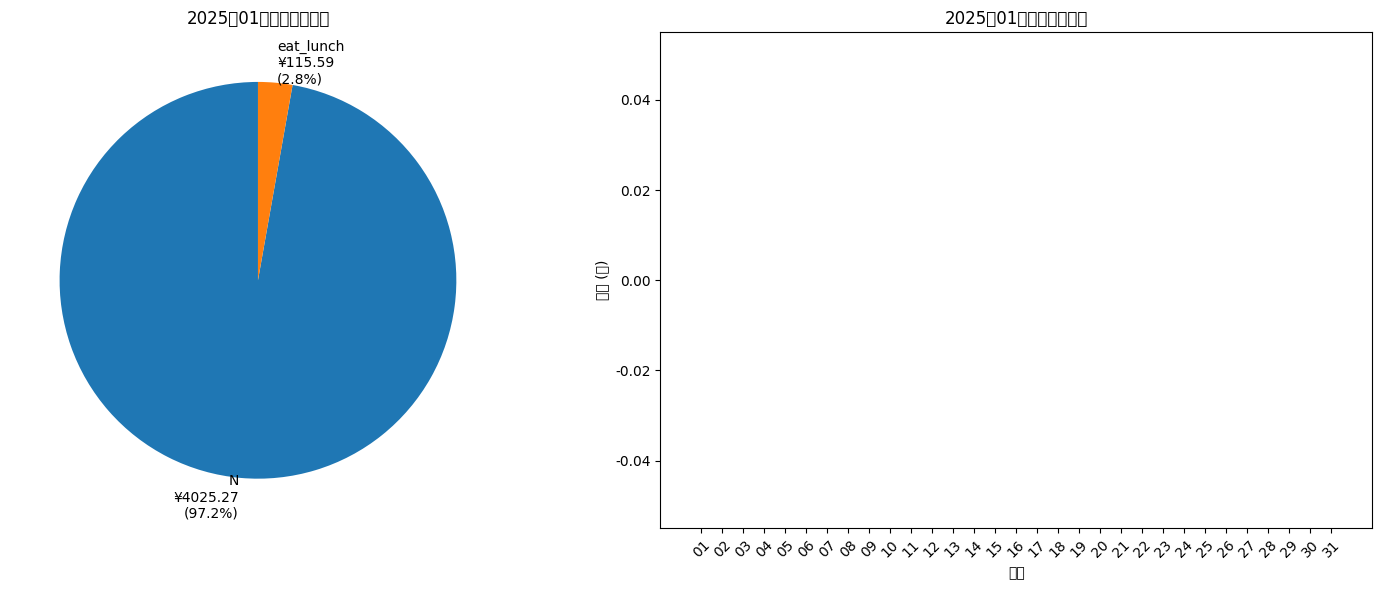


统计信息:
总消费: ¥4140.86
平均每日消费: ¥96.30

按标签统计:
          pay_money      
                sum count
pay_tag                  
N           4025.27    39
eat_lunch    115.59     4


In [36]:
# 输入 月份 绘制图表
# 总花费 - 已经在表格完成

params = {
    "monthyear": "202501"
}

# 饼状图 占比

# 日花费 曲线

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import calendar
import seaborn as sns

def get_month_date_range(monthyear):
    """获取指定月份的起止日期"""
    year = int(monthyear[:4])
    month = int(monthyear[4:])
    _, last_day = calendar.monthrange(year, month)
    start_date = f"{year}-{month:02d}-01"
    end_date = f"{year}-{month:02d}-{last_day}"
    return start_date, end_date

def query_monthly_data(cursor, params):
    """查询月度数据"""
    try:
        table_name = f"pay_{params['monthyear']}"
        
        # 检查表是否存在
        cursor.execute("""
            SELECT name FROM sqlite_master 
            WHERE type='table' AND name=?
        """, (table_name,))
        
        if not cursor.fetchone():
            return False, f"表格 {table_name} 不存在"
        
        # 查询所有数据
        query = f"SELECT pay_time, pay_money, pay_tag FROM {table_name}"
        cursor.execute(query)
        
        # 转换为DataFrame
        df = pd.DataFrame(cursor.fetchall(), columns=['pay_time', 'pay_money', 'pay_tag'])
        return True, df
        
    except sqlite3.Error as e:
        return False, f"数据库错误: {str(e)}"

def plot_monthly_charts(df, monthyear):
    """绘制月度图表"""
    # 设置中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 创建一个图形，包含两个子图
    fig = plt.figure(figsize=(15, 6))
    
    # 1. 饼图 - 按标签统计
    plt.subplot(121)
    
    # 计算每个标签的总金额
    tag_sum = df.groupby('pay_tag')['pay_money'].sum()
    
    # 对标签进行排序，确保相似标签相邻
    sorted_tags = sorted(tag_sum.index)
    tag_sum = tag_sum[sorted_tags]
    
    # 计算百分比
    total = tag_sum.sum()
    percentages = tag_sum / total * 100
    
    # 生成标签文本
    labels = [f'{tag}\n¥{amount:.2f}\n({percent:.1f}%)' 
              for tag, amount, percent in zip(tag_sum.index, tag_sum, percentages)]
    
    # 绘制饼图
    plt.pie(tag_sum, labels=labels, autopct='', startangle=90)
    plt.title(f'{monthyear[:4]}年{monthyear[4:]}月消费类别分布')
    
    # 2. 柱状图 - 按日期统计
    plt.subplot(122)
    
    # 生成完整的日期范围
    start_date, end_date = get_month_date_range(monthyear)
    date_range = pd.date_range(start=start_date, end=end_date)
    
    # 将日期转换为日期类型
    # df['pay_time'] = pd.to_datetime(df['pay_time'])
    df['pay_time'] = pd.to_datetime(df['pay_time'], format='%Y-%m-%d', errors='coerce')
    
    # 按日期分组求和
    daily_sum = df.groupby('pay_time')['pay_money'].sum()
    
    # 创建完整的日期序列，填充缺失值为0
    daily_sum_full = pd.Series(0, index=date_range)
    daily_sum_full.update(daily_sum)
    
    # 绘制柱状图
    plt.bar(daily_sum_full.index.strftime('%d'), daily_sum_full.values)
    plt.title(f'{monthyear[:4]}年{monthyear[4:]}月每日消费金额')
    plt.xlabel('日期')
    plt.ylabel('金额 (元)')
    plt.xticks(rotation=45)
    
    # 自动调整布局
    plt.tight_layout()
    
    return fig

def main():
    # 连接数据库
    conn = sqlite3.connect('moneycount.db')
    cursor = conn.cursor()
    
    # 查询参数
    params = {
        "monthyear": "202501"
    }
    
    try:
        # 查询数据
        success, result = query_monthly_data(cursor, params)
        
        if success:
            # 绘制图表
            fig = plot_monthly_charts(result, params['monthyear'])
            
            # 显示图表
            plt.show()
            
            # 输出统计信息
            print("\n统计信息:")
            print(f"总消费: ¥{result['pay_money'].sum():.2f}")
            print(f"平均每日消费: ¥{result['pay_money'].sum() / len(result['pay_money']):.2f}")
            print("\n按标签统计:")
            tag_stats = result.groupby('pay_tag').agg({
                'pay_money': ['sum', 'count']
            })
            print(tag_stats)
            
        else:
            print(f"错误: {result}")
            
    except Exception as e:
        print(f"错误: {str(e)}")
        
    finally:
        conn.close()

if __name__ == "__main__":
    main()


# 预算额度，线条

/tmp/ipykernel_9633/1424864634.py:163: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_9633/1424864634.py:163: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_9633/1424864634.py:163: UserWarning: Glyph 28040 (\N{CJK UNIFIED IDEOGRAPH-6D88}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_9633/1424864634.py:163: UserWarning: Glyph 36153 (\N{CJK UNIFIED IDEOGRAPH-8D39}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_9633/1424864634.py:163: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_9633/1424864634.py:163: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_9633/1424864634.py:163: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAP

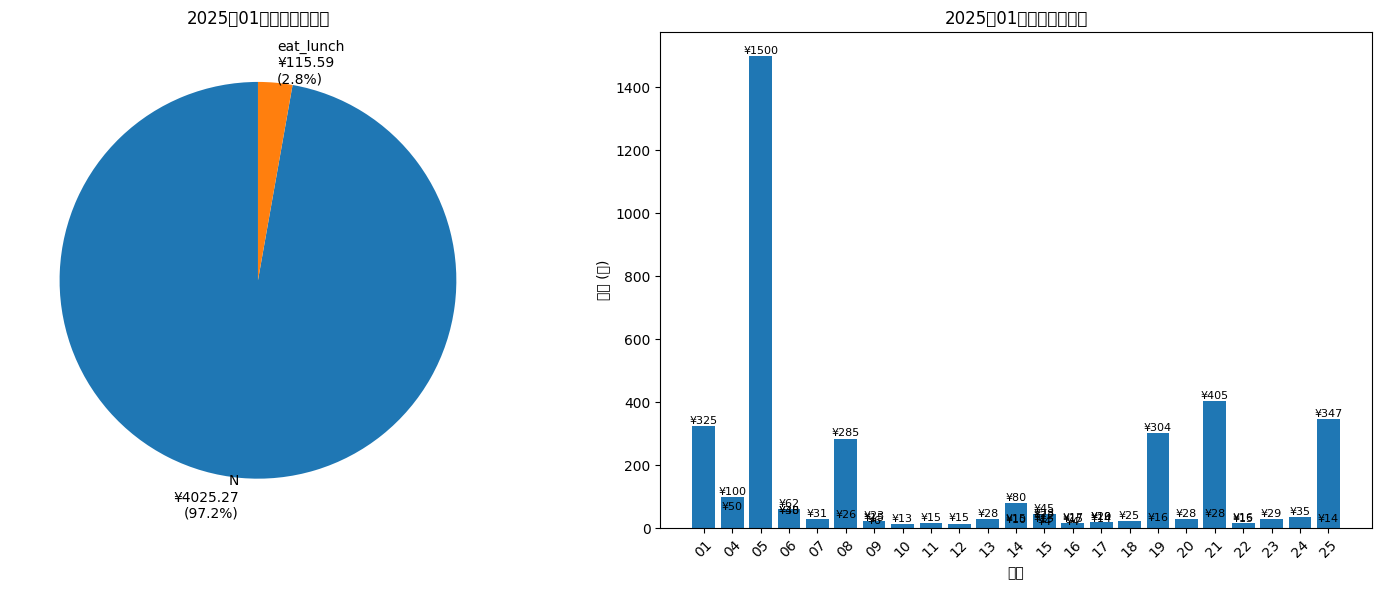


统计信息:
总消费: ¥4140.86
平均每日消费: ¥96.30

按标签统计:
          pay_money      
                sum count
pay_tag                  
N           4025.27    39
eat_lunch    115.59     4


In [50]:
# 输入 月份 绘制图表
# 总花费 - 已经在表格完成

params = {
    "monthyear": "202501"
}

# 饼状图 占比

# 日花费 曲线

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import calendar
import matplotlib as mpl

def get_month_date_range(monthyear):
    """获取指定月份的起止日期"""
    year = int(monthyear[:4])
    month = int(monthyear[4:])
    _, last_day = calendar.monthrange(year, month)
    start_date = f"{year}-{month:02d}-01"
    end_date = f"{year}-{month:02d}-{last_day}"
    return start_date, end_date

def query_monthly_data(cursor, params):
    """查询月度数据"""
    try:
        table_name = f"pay_{params['monthyear']}"
        
        # 检查表是否存在
        cursor.execute("""
            SELECT name FROM sqlite_master 
            WHERE type='table' AND name=?
        """, (table_name,))
        
        if not cursor.fetchone():
            return False, f"表格 {table_name} 不存在"
        
        # 查询所有数据
        query = f"SELECT pay_time, pay_money, pay_tag FROM {table_name}"
        cursor.execute(query)
        
        # 转换为DataFrame
        df = pd.DataFrame(cursor.fetchall(), columns=['pay_time', 'pay_money', 'pay_tag'])
        
        # 处理日期格式 - 使用更强大的日期解析
        df['pay_time'] = pd.to_datetime(df['pay_time'], errors='coerce', format='mixed')
        
        # 处理可能的NaT值
        df = df.dropna(subset=['pay_time'])
        
        return True, df
        
    except sqlite3.Error as e:
        return False, f"数据库错误: {str(e)}"

def plot_monthly_charts(df, monthyear):
    """绘制月度图表"""
    # 设置通用字体，避免使用特定的中文字体
    plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans', 'sans-serif']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 创建一个图形，包含两个子图
    fig = plt.figure(figsize=(15, 6))
    
    # 1. 饼图 - 按标签统计
    plt.subplot(121)
    
    # 计算每个标签的总金额
    tag_sum = df.groupby('pay_tag')['pay_money'].sum()
    
    # 对标签进行排序，确保相似标签相邻
    sorted_tags = sorted(tag_sum.index)
    tag_sum = tag_sum[sorted_tags]
    
    # 计算百分比
    total = tag_sum.sum()
    percentages = tag_sum / total * 100
    
    # 生成标签文本
    labels = [f'{tag}\n¥{amount:.2f}\n({percent:.1f}%)' 
              for tag, amount, percent in zip(tag_sum.index, tag_sum, percentages)]
    
    # 绘制饼图
    plt.pie(tag_sum, labels=labels, autopct='', startangle=90)
    plt.title(f'{monthyear[:4]}年{monthyear[4:]}月消费类别分布')
    
    # 2. 柱状图 - 按日期统计
    plt.subplot(122)
    
    # 生成完整的日期范围
    start_date, end_date = get_month_date_range(monthyear)
    date_range = pd.date_range(start=start_date, end=end_date)
    
    # 按日期分组求和
    daily_sum = df.groupby('pay_time')['pay_money'].sum()
    
    # 创建完整的日期序列，填充缺失值为0
    daily_sum_full = pd.Series(0, index=date_range)
    daily_sum_full.update(daily_sum)
    
    # 绘制柱状图
    # plt.bar(daily_sum.index.strftime('%d'), daily_sum.values)
    # plt.title(f'{monthyear[:4]}年{monthyear[4:]}月每日消费金额')
    # plt.xlabel('日期')
    # plt.ylabel('金额 (元)')
    # plt.xticks(rotation=45)

    # 绘制柱状图
    ax = plt.subplot(122)
    bars = ax.bar(daily_sum.index.strftime('%d'), daily_sum.values)
    
    # 在每个柱子上方显示金额
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # 只有当金额大于0时才显示标签
            ax.text(
                bar.get_x() + bar.get_width()/2., 
                height + 0.1,               # 稍微在柱子上方
                f'¥{height:.0f}',           # 显示金额，取整数
                ha='center',                # 水平居中对齐
                va='bottom',                # 垂直底部对齐
                fontsize=8                  # 字体大小适当调小
            )
    
    plt.title(f'{monthyear[:4]}年{monthyear[4:]}月每日消费金额')
    plt.xlabel('日期')
    plt.ylabel('金额 (元)')
    plt.xticks(rotation=45)


    # # gpto4 ========================
    # # 创建 DataFrame
    # # df = pd.DataFrame(results)

    # # 清理 pay_time 列并将其格式化为日期
    # df['pay_time'] = pd.to_datetime(df['pay_time'], errors='coerce').dt.date

    # # 如果有无效日期，提前处理
    # if df['pay_time'].isnull().any():
    #     print(f"警告: 有 {df['pay_time'].isnull().sum()} 个无效日期已被排除。")

    # # 过滤掉无日期的行
    # # df.dropna(subset=['pay_time'], inplace=True)

    # # 计算每日消费金额
    # daily_spending = df.groupby('pay_time', as_index=False)['pay_money'].sum()

    # # 绘制每日消费金额柱状图
    # plt.figure(figsize=(10, 6))
    # plt.bar(daily_spending['pay_time'], daily_spending['pay_money'], color='skyblue')
    # plt.title('每日消费金额')
    # plt.xlabel('日期')
    # plt.ylabel('消费金额 (¥)')
    # plt.xticks(rotation=45)
    # plt.tight_layout()
    # plt.show()
    
    # 自动调整布局
    plt.tight_layout()
    
    return fig

def main():
    # 连接数据库
    conn = sqlite3.connect('moneycount.db')
    cursor = conn.cursor()
    
    # 查询参数
    params = {
        "monthyear": "202501"
    }
    
    try:
        # 查询数据
        success, result = query_monthly_data(cursor, params)
        
        if success:
            # 绘制图表
            fig = plot_monthly_charts(result, params['monthyear'])
            
            # 显示图表
            plt.show()
            
            # 输出统计信息
            print("\n统计信息:")
            print(f"总消费: ¥{result['pay_money'].sum():.2f}")
            print(f"平均每日消费: ¥{result['pay_money'].sum() / len(result['pay_money']):.2f}")
            print("\n按标签统计:")
            tag_stats = result.groupby('pay_tag').agg({
                'pay_money': ['sum', 'count']
            })
            print(tag_stats)
            
        else:
            print(f"错误: {result}")
            
    except Exception as e:
        print(f"错误: {str(e)}")
        
    finally:
        conn.close()

if __name__ == "__main__":
    main()


# 预算额度，线条

In [17]:
# ai识别分期 银行卡

# 调用api接口
# 设定提示词
# 获取结果
# 保存为csv

In [ ]:
# 输入年份，绘制12个月份图表

In [ ]:
# 指定beancount 路径
# 输入beancount账户
# 转化为beancount文件

In [ ]:
# 打开beancount查看

In [ ]:
# 打开数据库，单条录入测试，结合fastapi

# 服务器部署

# 移动端快捷指令

In [ ]:
# 输入 两个月份 绘制图表

In [3]:

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from rich.console import Console
from rich.table import Table

# (保持原有的汇总代码不变)
# ...

def plot_payment_data(results):
    """
    根据支付数据绘图
    Args:
        results: 查询结果列表
    """
    # 创建 DataFrame
    df = pd.DataFrame(results)

    # 清理 pay_time 列并将其格式化为日期
    df['pay_time'] = pd.to_datetime(df['pay_time'], errors='coerce').dt.date

    # 如果有无效日期，提前处理
    if df['pay_time'].isnull().any():
        print(f"警告: 有 {df['pay_time'].isnull().sum()} 个无效日期已被排除。")

    # 过滤掉无日期的行
    df.dropna(subset=['pay_time'], inplace=True)

    # 计算每日消费金额
    daily_spending = df.groupby('pay_time', as_index=False)['pay_money'].sum()

    # 绘制每日消费金额柱状图
    plt.figure(figsize=(10, 6))
    plt.bar(daily_spending['pay_time'], daily_spending['pay_money'], color='skyblue')
    plt.title('每日消费金额')
    plt.xlabel('日期')
    plt.ylabel('消费金额 (¥)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 计算 pay_tag 的占比
    tags_summary = df.groupby('pay_tag', as_index=False).agg({'pay_money': 'sum'})
    tags_summary.sort_values(by='pay_money', ascending=False, inplace=True)

    # 绘制饼状图
    plt.figure(figsize=(10, 6))
    plt.pie(tags_summary['pay_money'], labels=tags_summary['pay_tag'], autopct='%1.1f%%', startangle=140)
    plt.title('不同标签的消费占比')
    plt.axis('equal')  # 使饼状图为圆形
    plt.tight_layout()
    plt.show()

def display_query_results(results, params):
    """
    使用rich库显示查询结果
    """
    console = Console()
    
    if not results:
        console.print("[red]没有找到数据[/red]")
        return
    
    # 创建表格
    table = Table(
        title=f"支付记录 ({params['monthyear']})",
        show_header=True,
        header_style="bold magenta",
        border_style="blue",
        title_style="bold cyan"
    )
    
    # 添加列
    table.add_column("日期", style="cyan")
    table.add_column("金额", justify="right", style="green")
    table.add_column("来源", style="yellow")
    table.add_column("标签", style="red")
    table.add_column("备注")
    
    # 添加数据行
    for row in results:
        money = f"¥{float(row['pay_money']):.2f}"
        table.add_row(
            row['pay_time'],
            money,
            row['pay_source'],
            row['pay_tag'],
            row.get('pay_note', '')
        )
    
    # 查询条件
    console.print("\n[bold yellow]查询条件:[/bold yellow]")
    console.print(f"标签: {params.get('tag', '所有')} | 关键词: {params.get('key', '无')} | 金额 < {params.get('lt', '无')} | 金额 > {params.get('gt', '无')}")

    # 打印表格
    console.print("\n")
    console.print(table)
    
    # 打印统计信息
    total_amount = sum(float(row['pay_money']) for row in results)
    console.print(f"\n[bold green]总金额: ¥{total_amount:.2f}[/bold green]")
    console.print(f"[dim]共 {len(results)} 条记录[/dim]")

    # 绘制图表
    plot_payment_data(results)

# 使用示例
def main():
    # 测试参数
    params = {
        "monthyear": "202501",
        "tag": "",
        "key": "",
        "lt": "",
        "gt": ""
    }
    
    # 创建数据库连接
    # conn = sqlite3.connect('moneycount.db')
    cursor = conn.cursor()
    
    # 执行查询
    success, result = query_payment_data(cursor, params)
    
    if success:
        display_query_results(result, params)
    else:
        console = Console()
        console.print(f"[red]错误: {result}[/red]")
    
    # 关闭连接
    conn.close()

if __name__ == "__main__":
    main()


NameError: name 'conn' is not defined